<a href="https://colab.research.google.com/github/wasayq5/DeepLearningSpring23/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [43]:
import seaborn as sns
import sys
import re, cgi
import numpy as np
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.layers import Dense, Activation, Dropout
from urllib.request import urlretrieve 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.optimizers import RMSprop


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [44]:
urlretrieve("https://www.gutenberg.org/cache/epub/70606/pg70606-images.html", 'weirdtales.txt')
weirdtales= open("weirdtales.txt", encoding='utf-8').read().lower()

urlretrieve("https://www.gutenberg.org/cache/epub/2554/pg2554-images.html", "crimepun.txt")
crimepun = open("crimepun.txt", encoding= "utf-8").read().lower()


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [45]:
print("Number of characters in Weird Tales: %d" % len(weirdtales))
print("Number of characters in Crime and Punishment: %d" % len(crimepun))

Number of characters in Weird Tales: 138758
Number of characters in Crime and Punishment: 1323536


<function matplotlib.pyplot.show(close=None, block=None)>

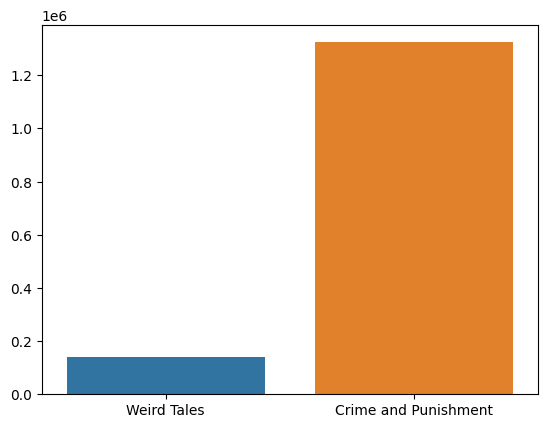

In [46]:
Texts = ["Weird Tales", "Crime and Punishment"]
Lengths = [len(weirdtales), len(crimepun)]

sns.barplot(x=Texts, y=Lengths)
plt.show

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [47]:
total_char = sorted(list(set(weirdtales+crimepun)))
indices_total_chars = dict((c, i) for i, c in enumerate(total_char))


seq_len = 60
step_size = 60
sentences_wt = []
sentences_cp = []

for i in range(0, len(weirdtales)-seq_len, step_size):
    sentences_wt.append(weirdtales[i:i+seq_len])

for i in range(0, len(crimepun)-seq_len, step_size):
    sentences_cp.append(crimepun[i:i+seq_len])

print(len(sentences_cp)+len(sentences_wt))

X = np.zeros((len(sentences_wt)+len(sentences_cp), seq_len, len(indices_total_chars)), dtype =float)
y = np.zeros((len(sentences_wt)+len(sentences_cp),2), dtype=float)

for i, sentence in enumerate(sentences_wt):
    for j, char in enumerate(sentence): 
        X[i,j,indices_total_chars[char]] = 1
    y[i][0] = 1

for i, sentence in enumerate(sentences_cp):
    for j, char in enumerate(sentence): 
        X[len(sentences_wt)+i,j,indices_total_chars[char]] = 1
    y[len(sentences_wt)+i][1] = 1

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", y.shape)


24370
Shape of the input data: (24370, 60, 83)
Shape of the target data: (24370, 2)


## Data splitting
Split the data into train, validate and test sets. Make 

In [48]:
train_ratio = 0.8
validate_ratio = 0.1
test_ratio = 0.1

wttrain_split = int(train_ratio * Lengths[0])
wtvalid_split = wttrain_split + int(validate_ratio * Lengths[0])

cptrain_split = Lengths[0] + int(train_ratio * Lengths[1])
cpvalid_split = cptrain_split + int(validate_ratio * Lengths[1])

X_train = np.concatenate((X[:wttrain_split], X[Lengths[0]:cptrain_split]), axis=0)
X_valid = np.concatenate((X[wttrain_split:wtvalid_split], X[cptrain_split:cpvalid_split]), axis=0) 
X_test = np.concatenate((X[wtvalid_split:Lengths[0]], X[cpvalid_split:]), axis=0)

Y_train = np.concatenate((y[:wttrain_split], y[Lengths[0]:cptrain_split]), axis=0)
Y_valid = np.concatenate((y[wttrain_split:wtvalid_split], y[cptrain_split:cpvalid_split]), axis=0)
Y_test = np.concatenate((y[wtvalid_split:Lengths[0]], y[cpvalid_split:]), axis=0)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [49]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1]))) # (batch, 128)
model.add(Dense(1, activation ='sigmoid'))

## Model training
Train the model and apply early stopping.

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [51]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

/usr/local/lib/python3.9/dist-packages/keras/utils/generic_utils.py:238: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

## Confusion matrix
Calculate and display the confusion matrix.

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


preds = model.predict(X_test)
cm = confusion_matrix(Y_test, np.rint(preds))

print("Accuracy:",accuracy_score(y_test, np.rint(preds)))
print("Precision:", precision_score(y_test, np.rint(preds)))
print("Recall:", recall_score(y_test, np.rint(preds), average='macro'))
print("F1:", f1_score(y_test, np.rint(preds), average='macro'))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ValueError: ignored